In [180]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchmetrics
import torchmetrics.classification
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [51]:
def set_seeds(seed: int = 42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general python random operation
    random.seed(42)
    # Set the seed for numpy operations
    np.random.seed(42)
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


In [52]:
set_seeds(42)

In [3]:
train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [7]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [16]:
len(train_data), len(test_data)

(60000, 10000)

In [17]:
batch_size = 32

train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

In [27]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {X.shape} {X.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32, 1, 28, 28]) torch.float32


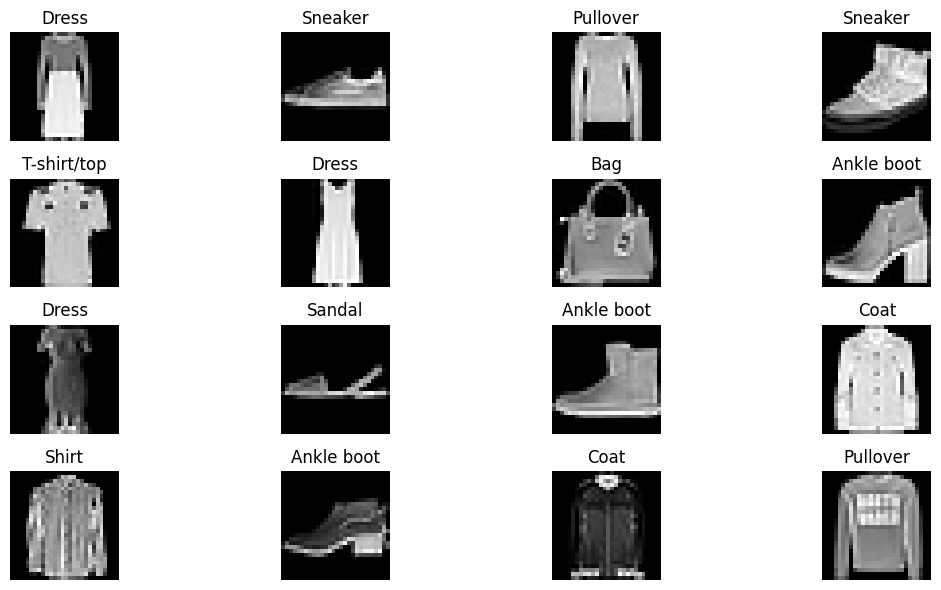

In [55]:
classes = train_data.classes
rows, cols = 4, 4

plt.figure(figsize=(12, 6))
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), [1]).item()
    image, labels = train_data[random_idx]

    plt.subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis(False)
    plt.title(f"{classes[labels]}")

plt.tight_layout()

In [64]:
class FashionMNISTModel(nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)

In [86]:
model = FashionMNISTModel(28 * 28, len(classes))

model

FashionMNISTModel(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [87]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [88]:
metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(classes))

In [89]:
def train(
    dataloader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    metric: torchmetrics.Metric,
):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        model.train()

        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, y)
        acc = metric(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    final_acc = metric.compute()
    metric.reset()

    return final_acc.item()

In [96]:
def test(
    dataloader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    metric: torchmetrics.Metric,
):
    num_batches = len(dataloader)

    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            model.eval()

            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(y_logits, y).item()
            acc = metric(y_pred, y)

    final_acc = metric.compute()
    metric.reset()

    test_loss /= num_batches

    print(
        f"Test Error: \n Accuracy: {(100*final_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

    return final_acc.item()

In [97]:
epochs = 1

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_acc = train(train_dataloader, model, loss_fn, optimizer, metric)
    test_acc = test(train_dataloader, model, loss_fn, metric)

Epoch 1
-------------------------------
loss: 0.226191  [   32/60000]
loss: 0.303606  [ 3232/60000]
loss: 0.272694  [ 6432/60000]
loss: 0.417344  [ 9632/60000]
loss: 0.360418  [12832/60000]
loss: 0.649327  [16032/60000]
loss: 0.278000  [19232/60000]
loss: 0.183661  [22432/60000]
loss: 0.391422  [25632/60000]
loss: 0.324268  [28832/60000]
loss: 0.424233  [32032/60000]
loss: 0.248317  [35232/60000]
loss: 0.274629  [38432/60000]
loss: 0.618818  [41632/60000]
loss: 0.516900  [44832/60000]
loss: 0.384479  [48032/60000]
loss: 0.359075  [51232/60000]
loss: 0.430148  [54432/60000]
loss: 0.455778  [57632/60000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.344288 



In [141]:
class CNNFashionMNISTModel(nn.Module):
    def __init__(self, in_channels: int, out_features: int) -> None:
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=8,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=16, kernel_size=3, stride=1, padding="same"
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=3, stride=1, padding="same"
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.fc(x)

        return x

In [142]:
cnn_model = CNNFashionMNISTModel(1, len(classes))

cnn_model


CNNFashionMNISTModel(
  (conv_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [143]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters())


In [144]:
epochs = 2

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_acc = train(train_dataloader, cnn_model, loss_fn, optimizer, metric)
    test_acc = test(train_dataloader, cnn_model, loss_fn, metric)


Epoch 1
-------------------------------
loss: 2.316027  [   32/60000]
loss: 0.873008  [ 3232/60000]
loss: 0.668433  [ 6432/60000]
loss: 0.859672  [ 9632/60000]
loss: 0.478637  [12832/60000]
loss: 0.770138  [16032/60000]
loss: 0.451730  [19232/60000]
loss: 0.326618  [22432/60000]
loss: 0.589332  [25632/60000]
loss: 0.683089  [28832/60000]
loss: 0.530271  [32032/60000]
loss: 0.487191  [35232/60000]
loss: 0.358006  [38432/60000]
loss: 0.602340  [41632/60000]
loss: 0.516212  [44832/60000]
loss: 0.375016  [48032/60000]
loss: 0.388912  [51232/60000]
loss: 0.366590  [54432/60000]
loss: 0.395581  [57632/60000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.356251 

Epoch 2
-------------------------------
loss: 0.392839  [   32/60000]
loss: 0.387310  [ 3232/60000]
loss: 0.211346  [ 6432/60000]
loss: 0.481170  [ 9632/60000]
loss: 0.242857  [12832/60000]
loss: 0.520344  [16032/60000]
loss: 0.336278  [19232/60000]
loss: 0.272443  [22432/60000]
loss: 0.537607  [25632/60000]
loss: 0.440242  [28832/60000

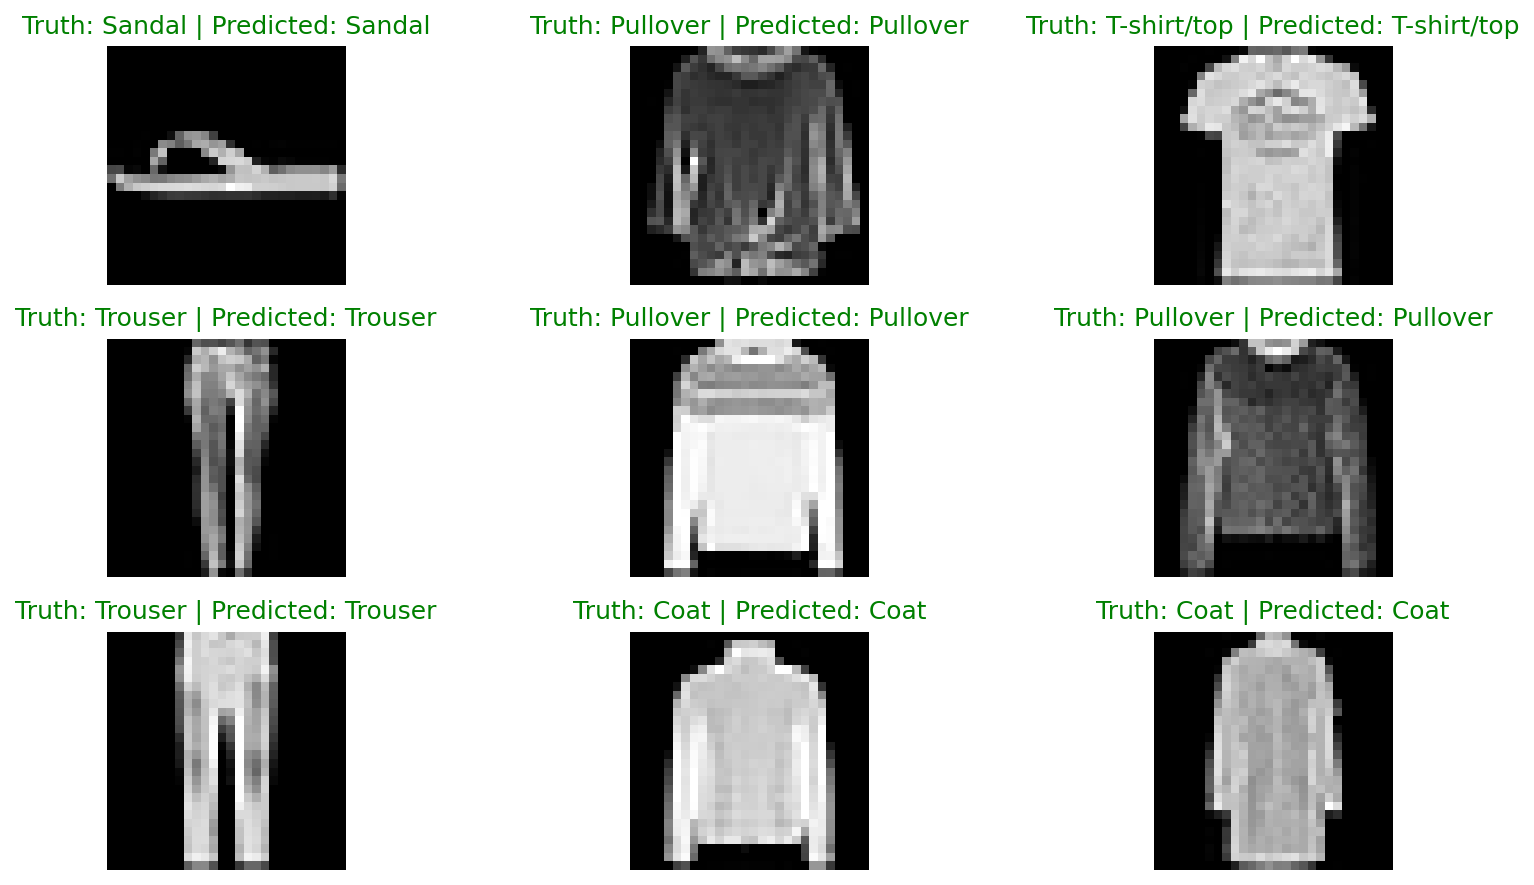

In [156]:
rows, cols = 3, 3
n_sample = 9
random_test = random.sample(list(test_data), n_sample)

plt.figure(figsize=(12, 6), dpi=150)
for i, (X, y) in enumerate(random_test):
    ground_truth = classes[y]

    cnn_model.eval()
    with torch.inference_mode():
        y_pred = cnn_model(X.unsqueeze(0))
        y_pred = classes[torch.softmax(y_pred, dim=1).argmax(1)]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(X.squeeze(), cmap="gray")
    plt.axis(False)

    title = f"Truth: {ground_truth} | Predicted: {y_pred}"

    if ground_truth == y_pred:
        plt.title(title, c="g")
    else:
        plt.title(title, c="r")

plt.tight_layout()

In [158]:
cm = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=len(classes))

In [173]:
cnn_model.eval()
with torch.inference_mode():
    test_logits = cnn_model(test_data.data.unsqueeze(1).type(torch.float))
    test_preds = torch.softmax(test_logits, dim=1).argmax(1)

test_preds


tensor([9, 2, 1,  ..., 8, 1, 5])

In [181]:
conf_mat = cm(test_preds, test_data.targets)

In [184]:
conf_mat

tensor([[906,  10,  32,   9,   4,   6,  20,   0,  13,   0],
        [  5, 981,   6,   3,   1,   3,   0,   0,   1,   0],
        [ 43,   6, 878,   4,  55,   2,   8,   0,   4,   0],
        [123, 101,  18, 672,  41,   2,  11,   0,  32,   0],
        [  7,   5, 208,  32, 707,   0,  25,   0,  16,   0],
        [  1,   0,   0,   0,   0, 992,   0,   3,   0,   4],
        [298,   3, 225,  13, 171,   5, 270,   0,  15,   0],
        [  0,   0,   0,   0,   0, 104,   0, 857,   1,  38],
        [ 21,   2,   3,   2,   2,  27,   1,   1, 940,   1],
        [  0,   0,   0,   0,   0,  18,   0,  33,   8, 941]])

<Axes: >

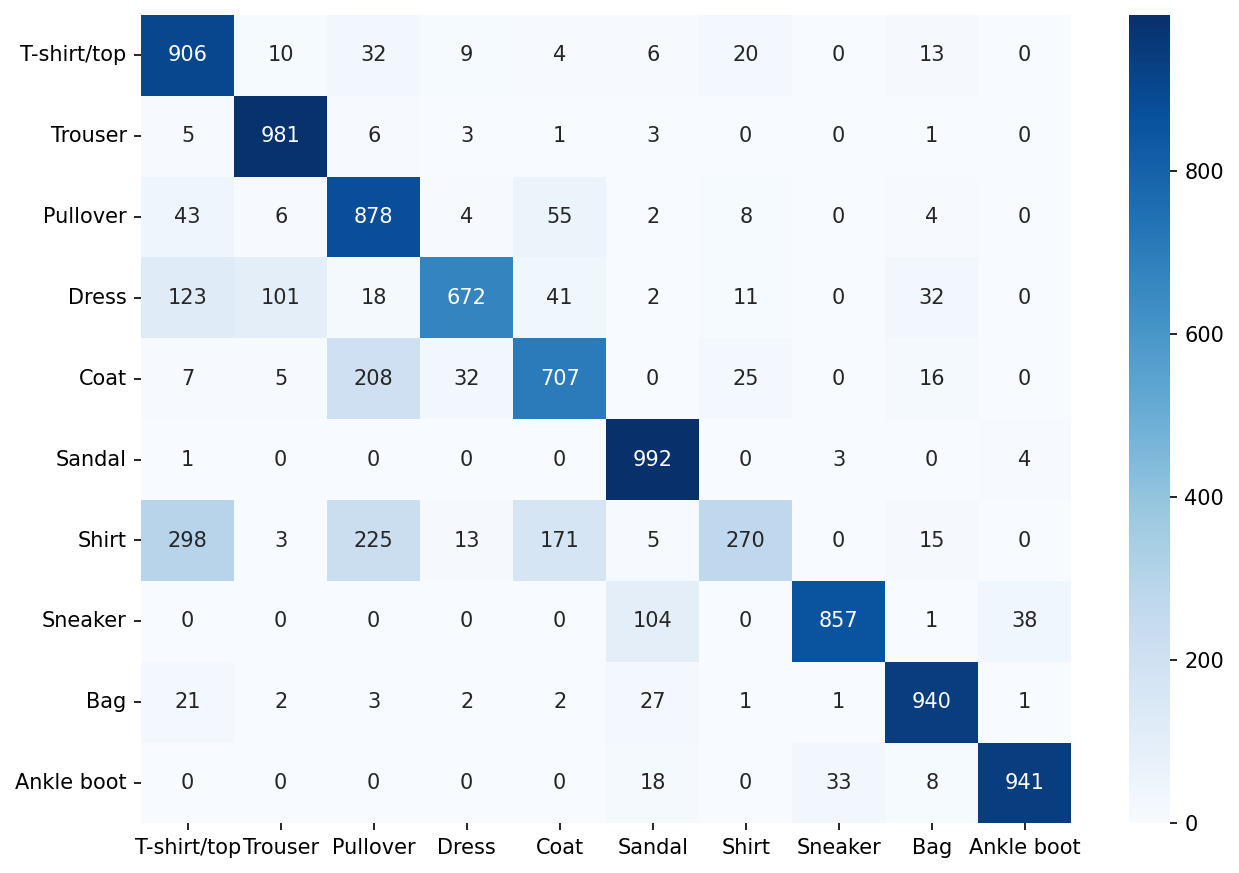

In [185]:
plt.figure(figsize=(10, 7), dpi=150)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)